In [1]:
import json
import math
import os
import keras
import cv2

from PIL import Image
import numpy as np
import seaborn as sns
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
import tensorflow 
from tqdm import tqdm

%matplotlib inline

In [2]:
train_df = pd.read_csv("C:/Users/U53R/Documents/THESIS/10-Fold/train/x_train_8.xls")
valid_df = pd.read_csv("C:/Users/U53R/Documents/THESIS/10-Fold/test/x_valid_8.xls")
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(3297, 2)
(365, 2)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [3]:
x = train_df['id_code']
y = train_df['diagnosis']

IMG_SIZE = 224
SEED = 2021

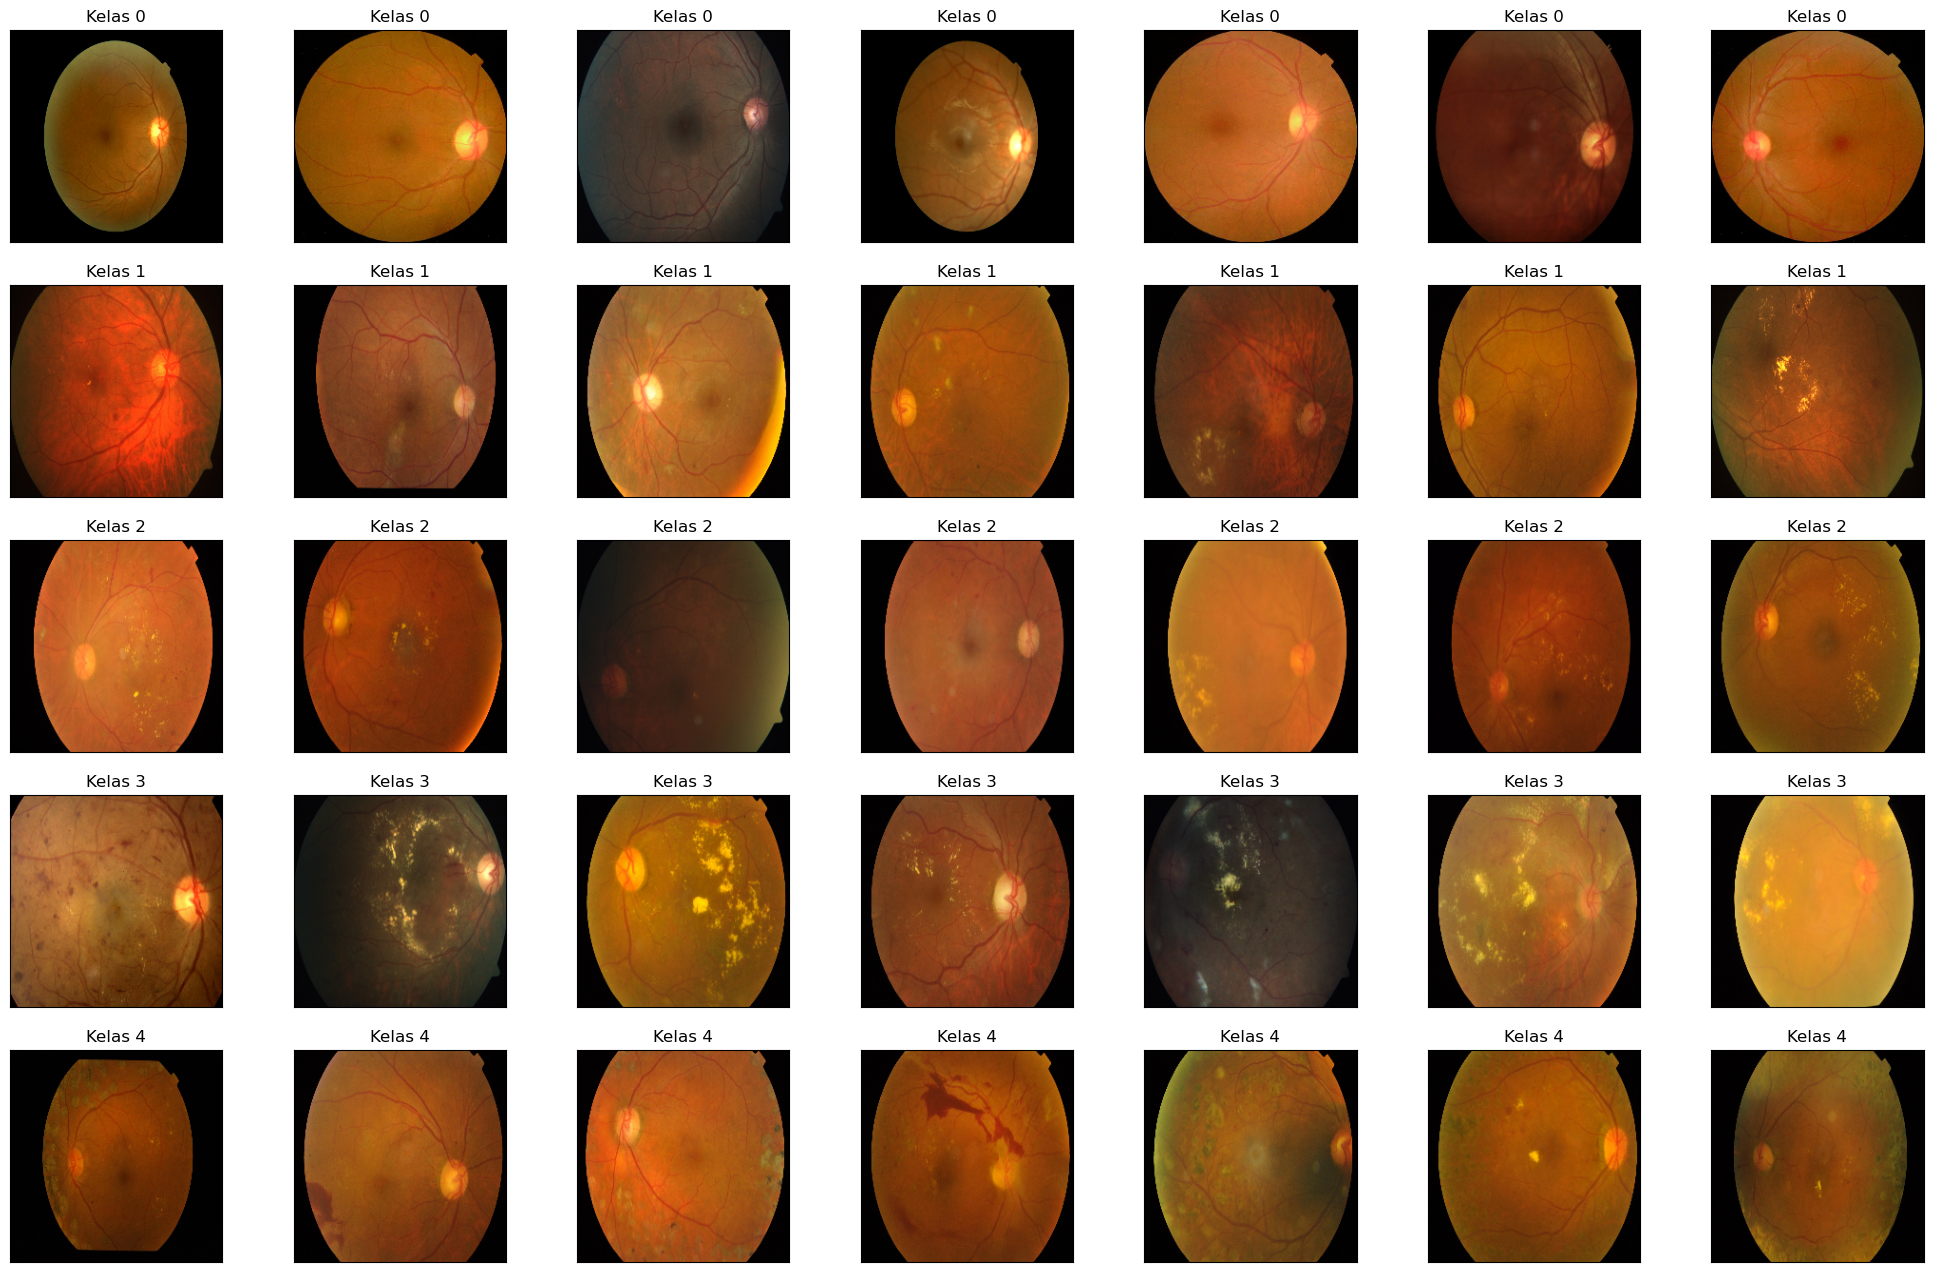

In [4]:
NUM_SAMP = 7

fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Kelas %d' % (class_id))

In [5]:
#resample
from sklearn.utils import resample
X=train_df
normal=X[X.diagnosis==0]
mild=X[X.diagnosis==1]
moderate=X[X.diagnosis==2]
severe=X[X.diagnosis==3]
pdr=X[X.diagnosis==4]

#downsampled
mild = resample(mild,
                replace=True, # sample with replacement
                n_samples=700, # match number in majority class
                random_state=2021) # reproducible results
moderate = resample(moderate,
                    replace=False, # sample with replacement
                    n_samples=700, # match number in majority class
                    random_state=2021) # reproducible results
severe = resample(severe,
                  replace=True, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2021) # reproducible results
normal = resample(normal,
                  replace=False, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2021) # reproducible results
pdr = resample(pdr,
               replace=True, # sample with replacement
               n_samples=700, # match number in majority class
               random_state=2021) # reproducible results

# combine minority and downsampled majority
sampled = pd.concat([normal, mild, moderate, severe, pdr])

train_df = sampled
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [6]:
print(train_df.shape)
print(valid_df.shape)

(3500, 2)
(365, 2)


In [7]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [8]:
def circle_crop(img, sigmaX=10):

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img

In [9]:
def preprocess_image(path, sigmaX=10):
    img = cv2.imread(path)
    img = crop_image_from_gray(img)
    # img = circle_crop(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert RGB
    r, g, b = cv2.split(img) #memisahkan 3 kanal warna
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)) #CLAHE
    # img = clahe.apply(r) #channel red
    img = clahe.apply(g) #channel green
    # img = clahe.apply(b) #channel blue
    # img = cv2.merge((b,img,r)) #gabung
    img = np.stack([img]*3, axis=-1) #stack 3 kanal
    img = cv2.resize(img, (224,224))
    
    return img

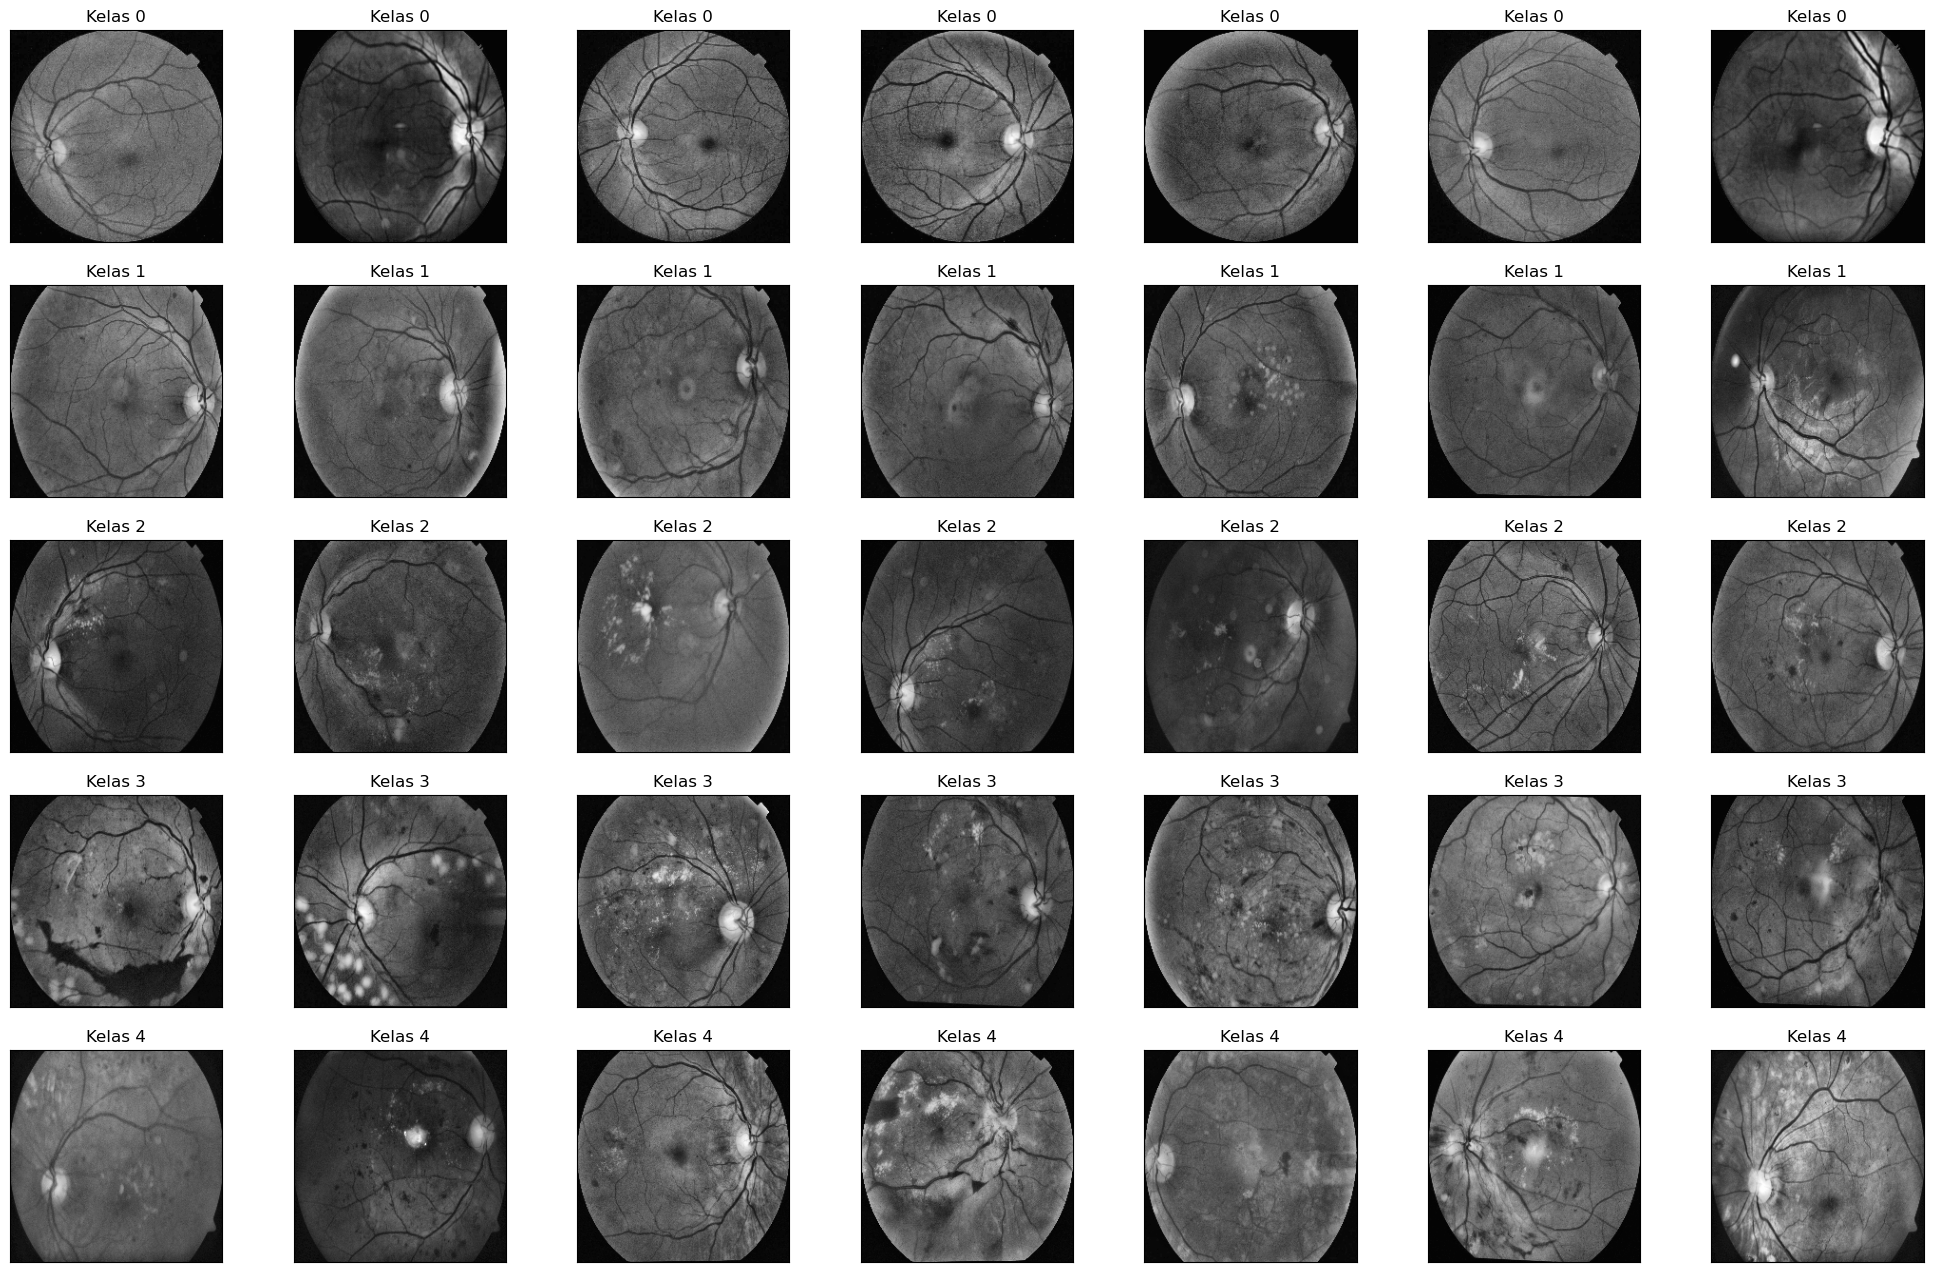

In [10]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED ).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = preprocess_image(path,sigmaX=10)

        plt.imshow(image)
        ax.set_title('Kelas %d' % (class_id) )

In [11]:
N = train_df.shape[0]
x_train = np.empty((N, 224,224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{image_id}.png')

N = valid_df.shape[0]
x_valid = np.empty((N, 224,224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(valid_df['id_code'])):
    x_valid[i, :, :, :] = preprocess_image(
        f'C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 365/365 [01:01<00:00,  5.90it/s]


In [12]:
y_train = tensorflow.keras.utils.to_categorical(train_df['diagnosis'], num_classes=5)
y_val = tensorflow.keras.utils.to_categorical(valid_df['diagnosis'], num_classes=5)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_val.shape)

(3500, 224, 224, 3)
(3500, 5)
(365, 224, 224, 3)
(365, 5)


In [13]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))
print('-------------------------------')
print(np.min(x_valid), np.max(x_valid))
print(np.min(y_val), np.max(y_val))

1.0 255.0
0.0 1.0
-------------------------------
1.0 255.0
0.0 1.0


In [14]:
# from tensorflow.keras.applications.resnet50 import preprocess_input

# x_train = preprocess_input(x_train)
# x_valid = preprocess_input(x_valid)

In [15]:
# BATCH_SIZE = 32

# def create_datagen():
#     return ImageDataGenerator(
#         zoom_range=0.9,  # set range for random zoom
#         rotation_range = 45, # set range for random rotation
#         # fill_mode='constant',
#         # cval=0,
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True,  # randomly flip images
#     )

# # Using original generator
# data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2021)

In [16]:
BATCH_SIZE = 32

datagen = ImageDataGenerator(
        zoom_range=0.9,  # set range for random zoom
        rotation_range = 45, # set range for random rotation
        # fill_mode='constant',
        # cval=0,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
data_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [17]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))
print('-------------------------------')
print(np.min(x_valid), np.max(x_valid))
print(np.min(y_val), np.max(y_val))

1.0 255.0
0.0 1.0
-------------------------------
1.0 255.0
0.0 1.0


# Model Load

In [19]:
model = load_model("D:/THESIS/JURNAL/DRAFT THESIS/MobileNet/fold-green kanal/resnet/fold_8.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,367 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

Submit

12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
Accuracy Valid: 0.7726027397260274


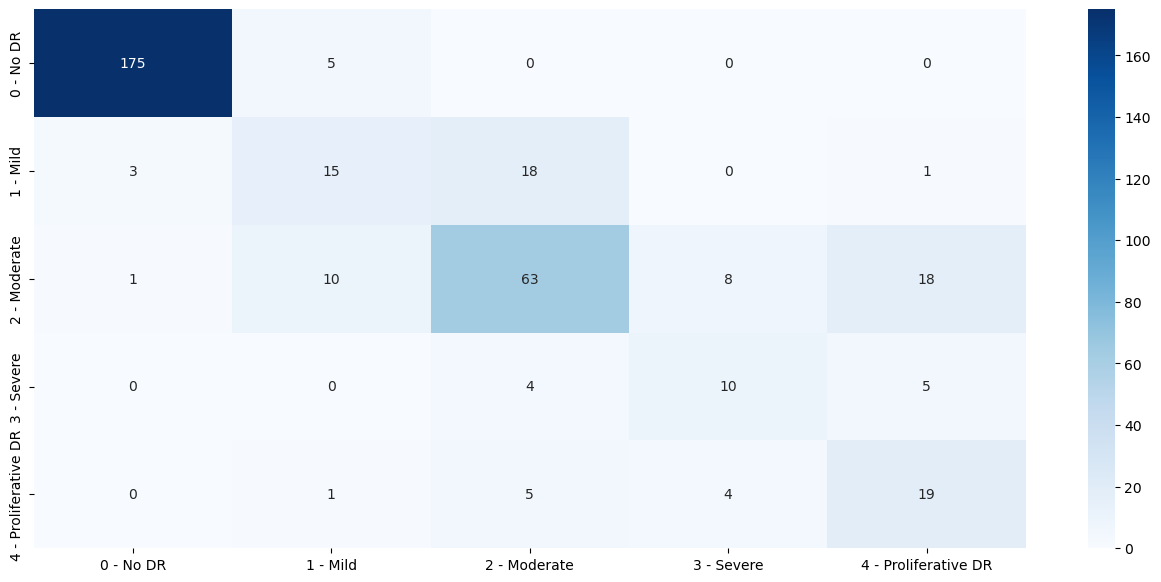

In [21]:
from sklearn.metrics import roc_auc_score

pred = model.predict(x_valid)
y_pred_classes = np.argmax(pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy Valid: {accuracy}")

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f',cmap="Blues")
plt.show()

In [22]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.98      0.97      0.97       180
            1 - Mild       0.48      0.41      0.44        37
        2 - Moderate       0.70      0.63      0.66       100
          3 - Severe       0.45      0.53      0.49        19
4 - Proliferative DR       0.44      0.66      0.53        29

            accuracy                           0.77       365
           macro avg       0.61      0.64      0.62       365
        weighted avg       0.78      0.77      0.77       365



## ROC Curve

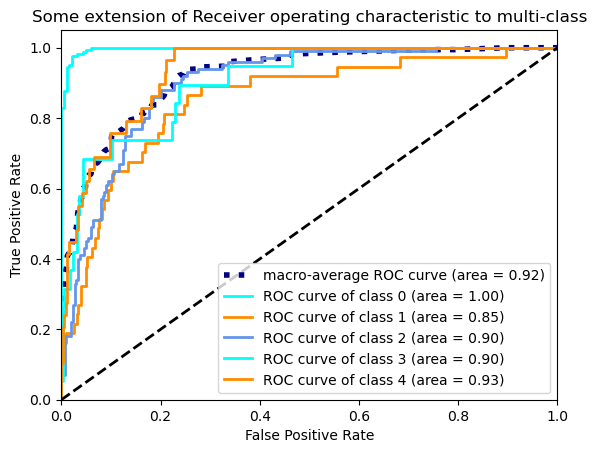

In [24]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Classifier

In [46]:
import keras

layer_name = 'dropout'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_layer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,636,800 (93.98 MB)

 Trainable params: 24,583,680 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [48]:
y_train_pred = intermediate_layer_model.predict(x_train)
y_valid_pred = intermediate_layer_model.predict(x_valid)

110/110 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step


In [49]:
print(y_train_pred.shape)
print(y_valid_pred.shape)

(3500, 512)
(365, 512)


# SVM

In [51]:
# classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

clf = SVC(probability=True)
y_score = clf.fit(y_train_pred, np.argmax(y_train, axis=1)).decision_function(y_valid_pred)
pred = clf.predict(y_valid_pred)

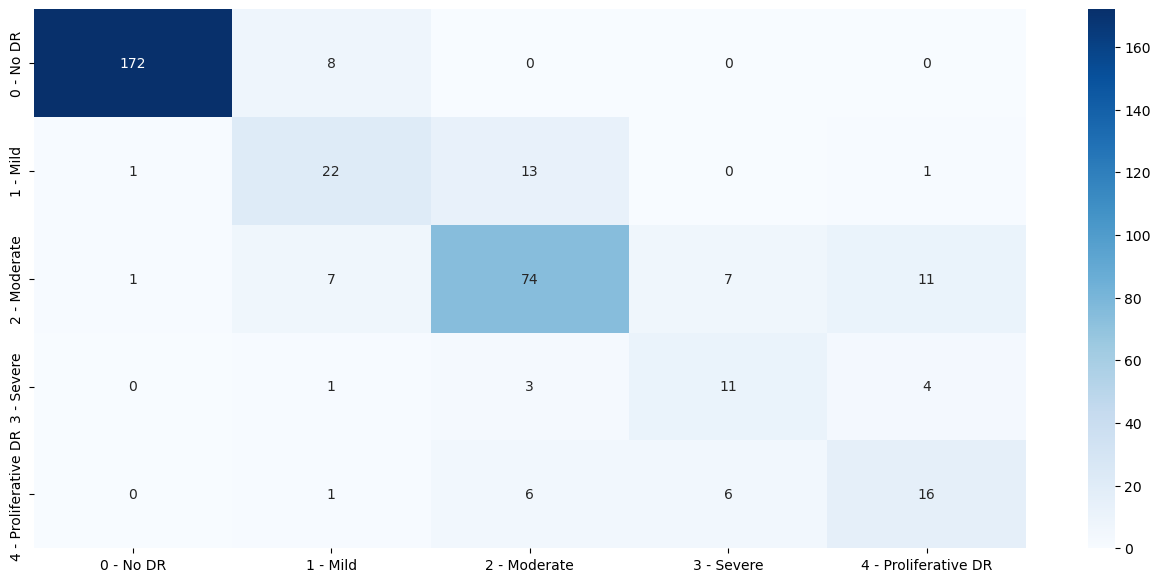

In [52]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val,axis=1), pred)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [53]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val,axis=1), pred, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.96      0.97       180
            1 - Mild       0.56      0.59      0.58        37
        2 - Moderate       0.77      0.74      0.76       100
          3 - Severe       0.46      0.58      0.51        19
4 - Proliferative DR       0.50      0.55      0.52        29

            accuracy                           0.81       365
           macro avg       0.66      0.68      0.67       365
        weighted avg       0.82      0.81      0.81       365



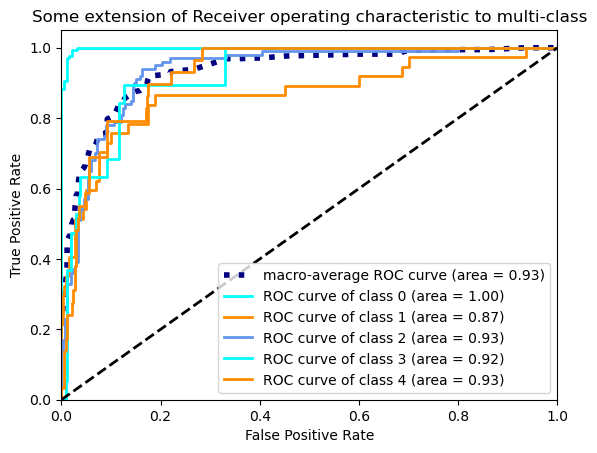

In [54]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [56]:
# classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

clf2 = RandomForestClassifier()
y_score2 = clf2.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_rf = clf2.predict(y_valid_pred)
# y_score2 = clf2.predict_proba(y_valid_pred)

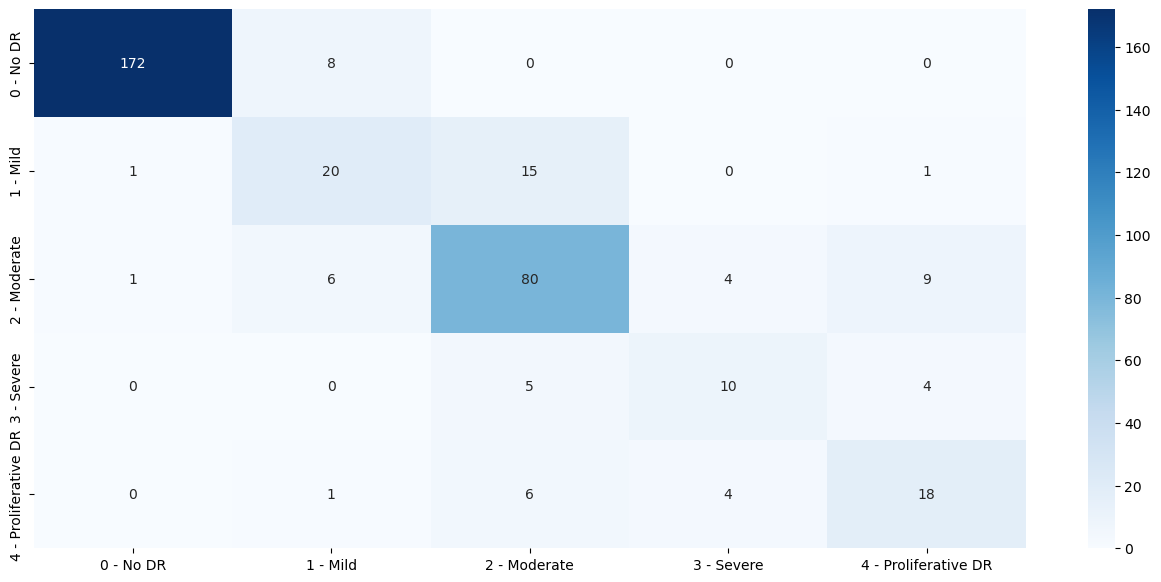

In [57]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_rf)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f',cmap="Blues")
plt.show()

In [58]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val, axis=1), pred_rf, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.96      0.97       180
            1 - Mild       0.57      0.54      0.56        37
        2 - Moderate       0.75      0.80      0.78       100
          3 - Severe       0.56      0.53      0.54        19
4 - Proliferative DR       0.56      0.62      0.59        29

            accuracy                           0.82       365
           macro avg       0.69      0.69      0.69       365
        weighted avg       0.83      0.82      0.82       365



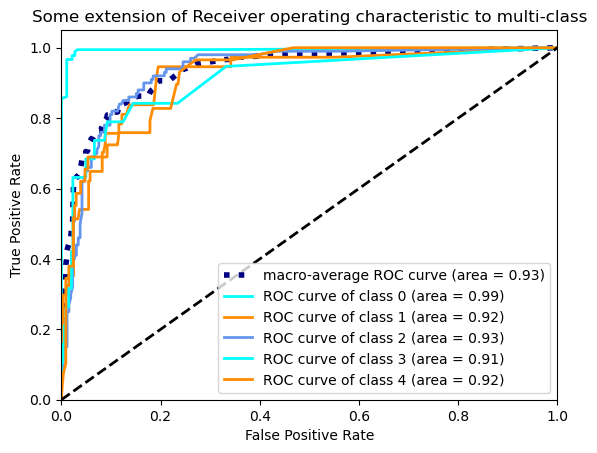

In [59]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [61]:
# classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf3 = LogisticRegression()
y_score3 = clf3.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_lr = clf3.predict(y_valid_pred)

C:\Users\U53R\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


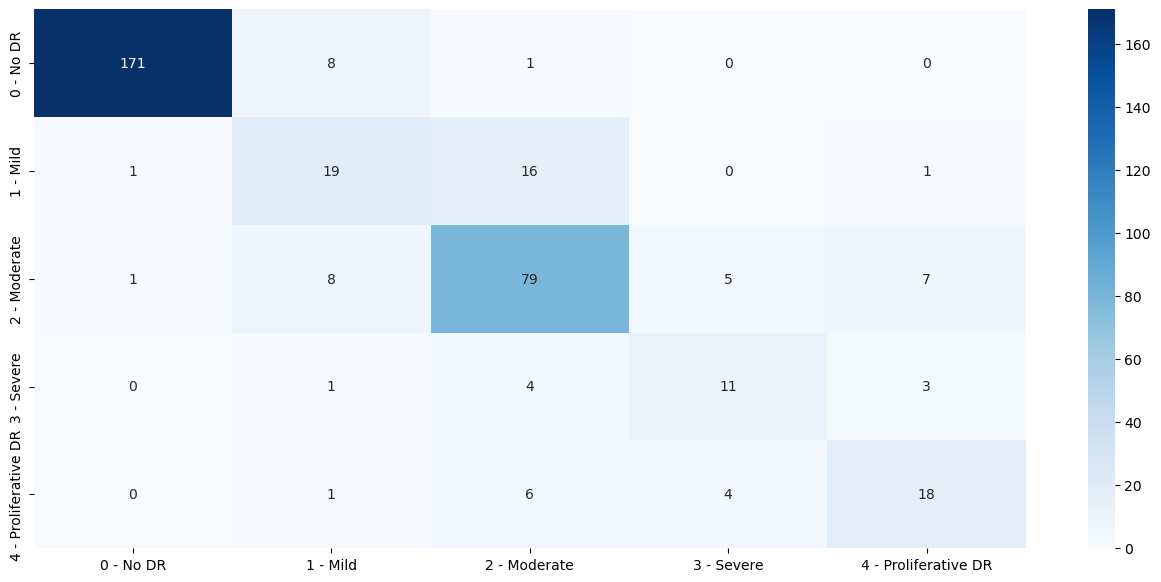

In [62]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val,axis=1), pred_lr)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [63]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val,axis=1), pred_lr, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.95      0.97       180
            1 - Mild       0.51      0.51      0.51        37
        2 - Moderate       0.75      0.79      0.77       100
          3 - Severe       0.55      0.58      0.56        19
4 - Proliferative DR       0.62      0.62      0.62        29

            accuracy                           0.82       365
           macro avg       0.68      0.69      0.69       365
        weighted avg       0.82      0.82      0.82       365



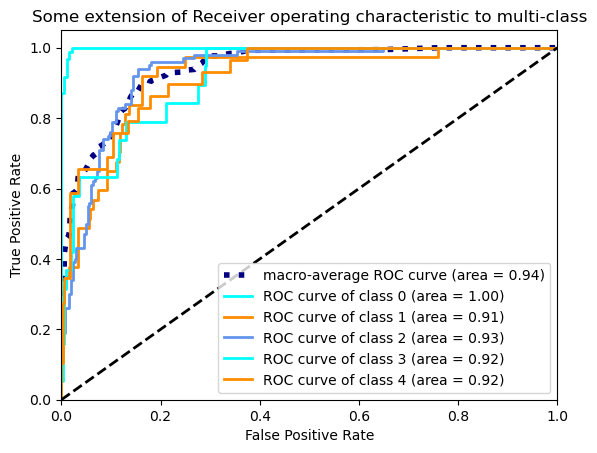

In [64]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score3.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Ensemble Model

### SVM+RF+LR

In [67]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(
    estimators=[('svm', clf), ('rf', clf2), ('lr', clf3)],
    voting='soft'
)

y_score4 = eclf.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_srl = eclf.predict(y_valid_pred)

C:\Users\U53R\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


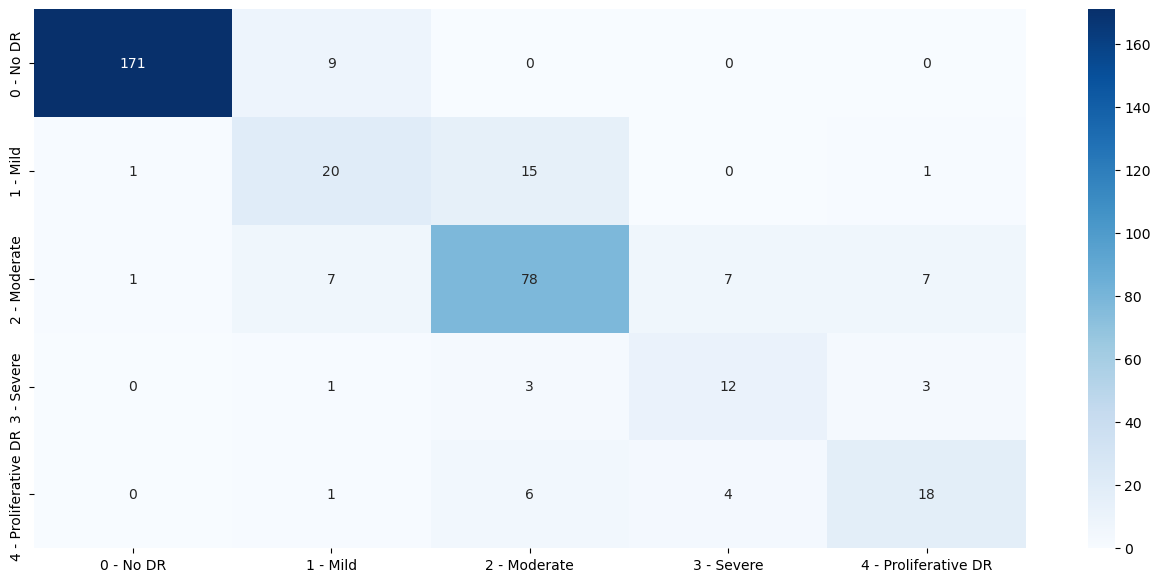

In [68]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_srl)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [69]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val, axis=1), pred_srl, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.95      0.97       180
            1 - Mild       0.53      0.54      0.53        37
        2 - Moderate       0.76      0.78      0.77       100
          3 - Severe       0.52      0.63      0.57        19
4 - Proliferative DR       0.62      0.62      0.62        29

            accuracy                           0.82       365
           macro avg       0.68      0.70      0.69       365
        weighted avg       0.83      0.82      0.82       365



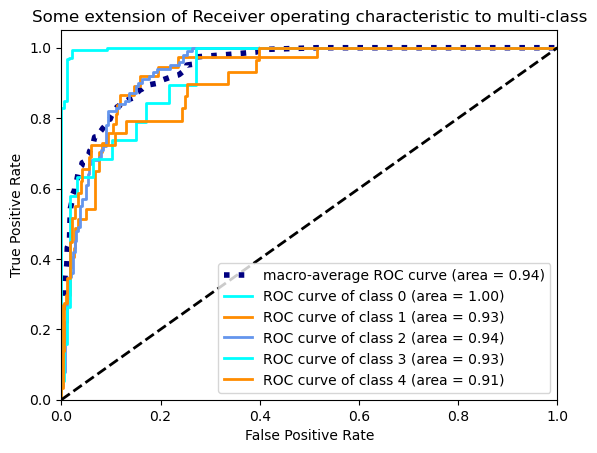

In [70]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score4[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score4.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### SVM+RF

In [72]:
from sklearn.ensemble import VotingClassifier

eclf2 = VotingClassifier(
    estimators=[('svm', clf), ('rf', clf2)],
    voting='soft'
)

y_eclf = eclf2.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_sr = eclf2.predict(y_valid_pred)

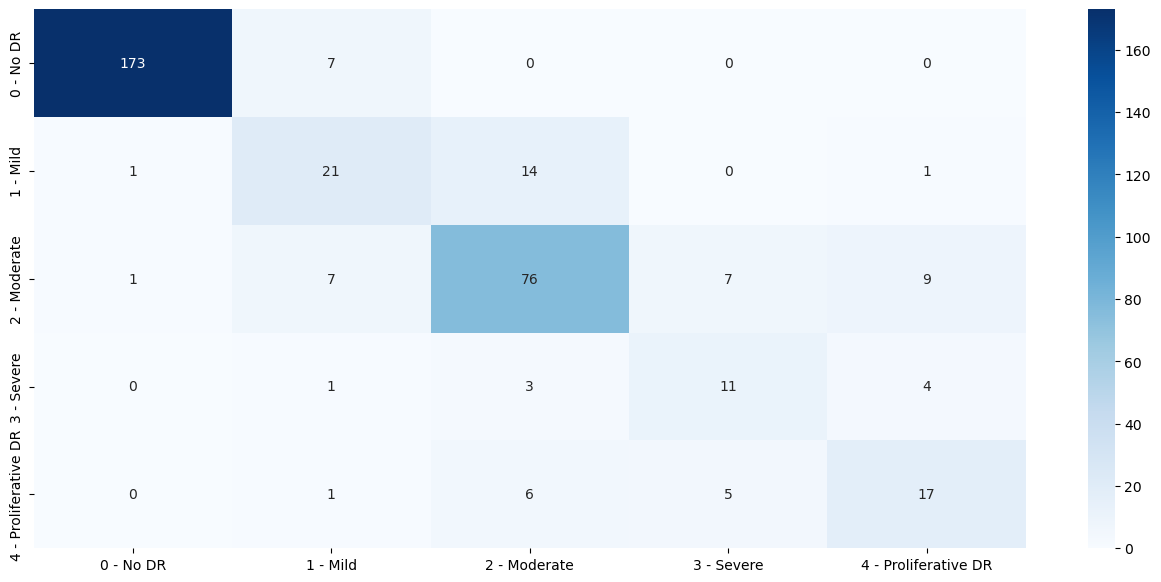

In [73]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_sr)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [74]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val, axis=1), pred_sr, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.96      0.97       180
            1 - Mild       0.57      0.57      0.57        37
        2 - Moderate       0.77      0.76      0.76       100
          3 - Severe       0.48      0.58      0.52        19
4 - Proliferative DR       0.55      0.59      0.57        29

            accuracy                           0.82       365
           macro avg       0.67      0.69      0.68       365
        weighted avg       0.82      0.82      0.82       365



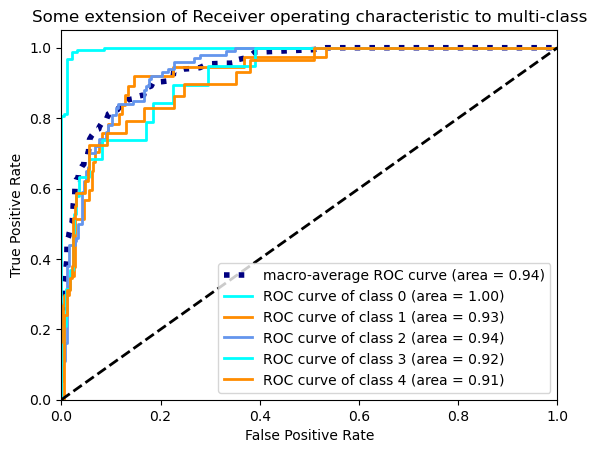

In [75]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_eclf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_eclf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### SVM+LR

In [77]:
from sklearn.ensemble import VotingClassifier

eclf3 = VotingClassifier(
    estimators=[('svm', clf), ('lr', clf3)],
    voting='soft'
)

y_eclf2 = eclf3.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_sl = eclf3.predict(y_valid_pred)

C:\Users\U53R\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


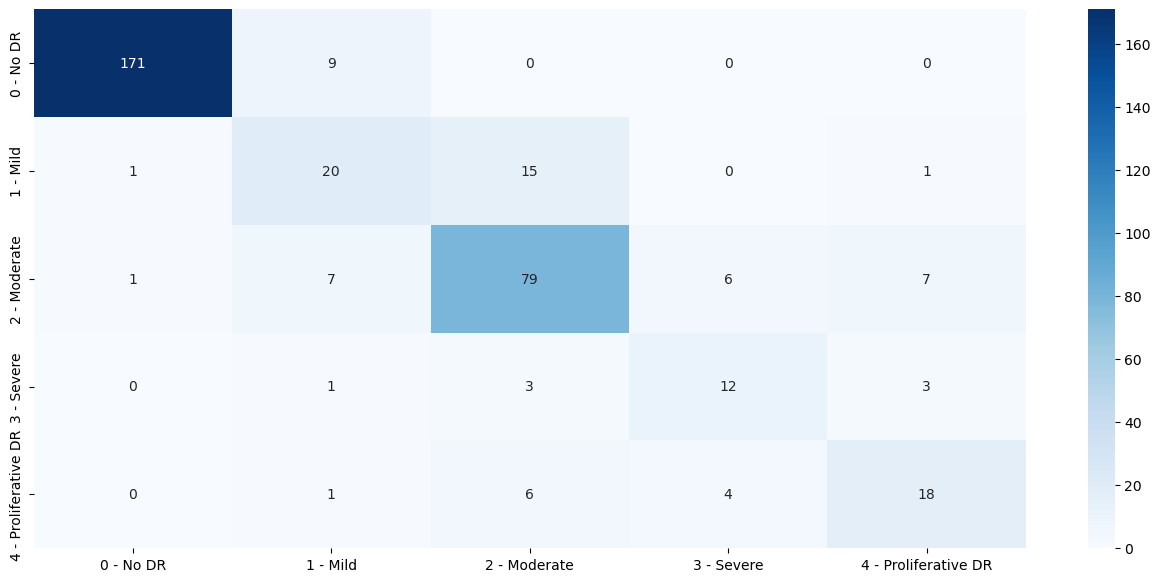

In [78]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_sl)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [79]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val, axis=1), pred_sl, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.95      0.97       180
            1 - Mild       0.53      0.54      0.53        37
        2 - Moderate       0.77      0.79      0.78       100
          3 - Severe       0.55      0.63      0.59        19
4 - Proliferative DR       0.62      0.62      0.62        29

            accuracy                           0.82       365
           macro avg       0.69      0.71      0.70       365
        weighted avg       0.83      0.82      0.82       365



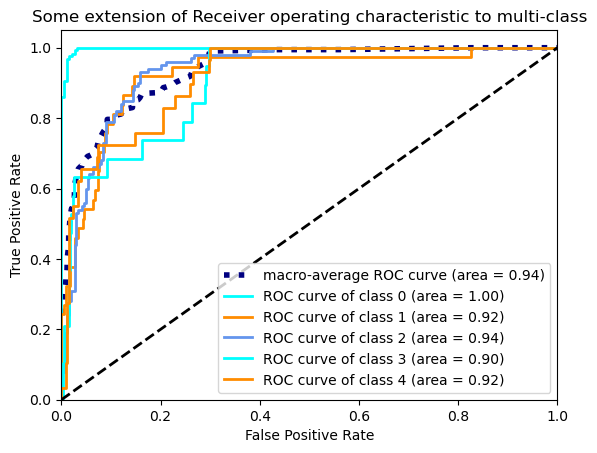

In [80]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_eclf2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_eclf2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### RF+LR

In [82]:
from sklearn.ensemble import VotingClassifier

eclf4 = VotingClassifier(
    estimators=[('rf', clf2), ('lr', clf3)],
    voting='soft'
)

y_eclf3 = eclf4.fit(y_train_pred, np.argmax(y_train, axis=1)).predict_proba(y_valid_pred)
pred_rl = eclf4.predict(y_valid_pred)

C:\Users\U53R\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


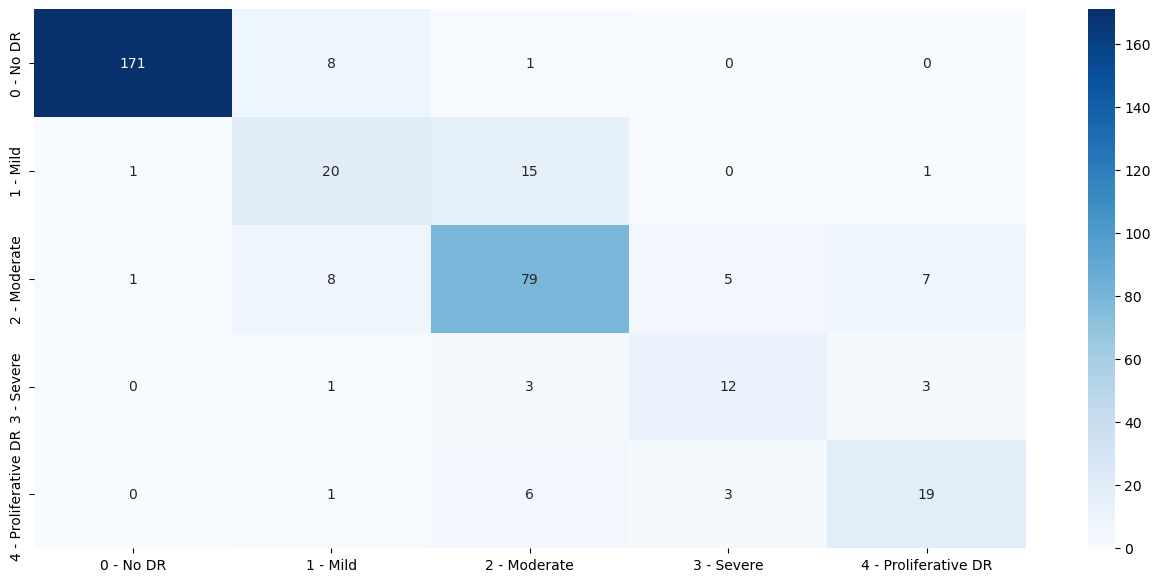

In [83]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), pred_rl)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [84]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val, axis=1), pred_rl, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.99      0.95      0.97       180
            1 - Mild       0.53      0.54      0.53        37
        2 - Moderate       0.76      0.79      0.77       100
          3 - Severe       0.60      0.63      0.62        19
4 - Proliferative DR       0.63      0.66      0.64        29

            accuracy                           0.82       365
           macro avg       0.70      0.71      0.71       365
        weighted avg       0.83      0.82      0.83       365



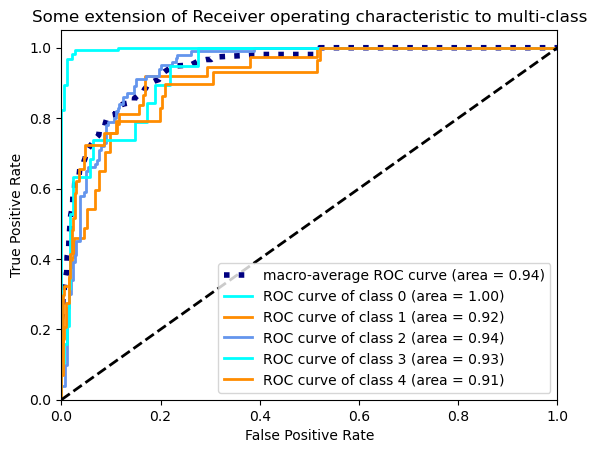

In [85]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_eclf3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_eclf3.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from itertools import cycle
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()